In [1]:
#!pip install -q numpyro@git+https://github.com/pyro-ppl/numpyro

In [2]:
#import os
#os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [14]:
import os
import sys
import time
import numpy as np 
import matplotlib.pyplot as plt 

# Numpyro
import numpyro
import numpyro.distributions as npdist
import random as rnd
from numpyro.infer import Predictive, init_to_median, init_to_feasible, MCMC, NUTS
from numpyro.diagnostics import hpdi

numpyro.set_host_device_count(4)

#JAX
import jax
from jax import random
import jax.numpy as jnp
from jax import vmap

from tqdm import tqdm, trange

import arviz
import dill

print(numpyro.__version__)
print(jax.__version__)

0.10.1
0.3.25


## GP priors

In [15]:
def dist_euclid(x, z):
    x = jnp.array(x) 
    z = jnp.array(z)
    if len(x.shape)==1:
        x = x.reshape(x.shape[0], 1)
    if len(z.shape)==1:
        z = z.reshape(z.shape[0], 1)
    n_x, m = x.shape
    n_z, m_z = z.shape
    assert m == m_z
    delta = jnp.zeros((n_x,n_z))
    for d in jnp.arange(m):
        x_d = x[:,d]
        z_d = z[:,d]
        delta += (x_d[:,jnp.newaxis] - z_d)**2
    return jnp.sqrt(delta)

def exp_sq_kernel(x, z, var, length, noise=0, jitter=1.0e-5):
    dist = dist_euclid(x, z)
    deltaXsq = jnp.power(dist/ length, 2.0)
    k = var * jnp.exp(-0.5 * deltaXsq)
    k += (noise + jitter) * jnp.eye(x.shape[0])
    return k

def GP(x, jitter=1e-5, var=1.0, length=None, y=None, noise=False, gp_kernel=exp_sq_kernel):

    if length==None:  
        length = numpyro.sample("length", npdist.Uniform(0.01,0.99)) 
            
    k = gp_kernel(x, x, var, length, jitter)
    
    if noise==False:
        y = numpyro.sample("y",  npdist.MultivariateNormal(loc=jnp.zeros(x.shape[0]), covariance_matrix=k), obs=y)
    else:
        sigma = numpyro.sample("noise", npdist.HalfNormal(0.1))
        f = numpyro.sample("f", npdist.MultivariateNormal(loc=jnp.zeros(x.shape[0]), covariance_matrix=k))
        y = numpyro.sample("y", npdist.Normal(f, sigma), obs=y)

## Generate data

Text(0.5, 1.0, 'Ground truth, corresponds to ls=0.2')

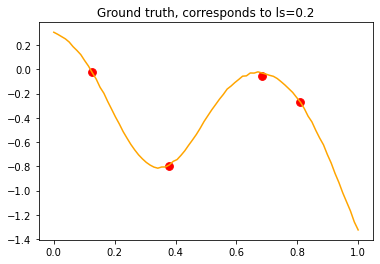

In [16]:
n_dataPoints = 80
x = np.linspace(0, 1,n_dataPoints)   

args = {
        "x": x,
        "gp_kernel": exp_sq_kernel,
        "num_warmup": 5000,
        "num_samples": 50000,
        "num_chains": 3,
        "thinning": 1,
        "x_pred": x,
        "true_ls": 0.2
        }

rng_key_draw =  random.PRNGKey(1)
rng_key, rng_key_post, rng_key_preds, rng_key_draw = random.split(rng_key_draw, 4)

gp_predictive = Predictive(GP, num_samples=1)
draws = gp_predictive(rng_key_draw, x=x, jitter=1e-6, 
                      noise=True, length=args["true_ls"], var=1)

gp_draw = draws['f'].T
y_draw = draws['y'].T

obs_idx_lst = []
obs_idx_lst.append([10, 30, 54, 64]) # points correspond to n=80, ls=0.2, rng1

i = 0

# choose indices of data points for inference
obs_idx = jnp.array(obs_idx_lst[i])

y_obs = y_draw[obs_idx,0]
x_obs = x[np.array(obs_idx)]

args['y_obs'] = y_obs
args['obs_idx'] = obs_idx
args['x_obs'] = x_obs

plt.plot(x, gp_draw, label="ground truth", color="orange")
plt.scatter(x_obs, y_obs, color="red", label="observed data", s=60)
plt.title('Ground truth, corresponds to ls=' + str(args["true_ls"]))

## Approach 3

In [17]:
args.keys()

dict_keys(['x', 'gp_kernel', 'num_warmup', 'num_samples', 'num_chains', 'thinning', 'x_pred', 'true_ls', 'y_obs', 'obs_idx', 'x_obs'])

In [18]:
def GP_model(args, length=None, y=None, var=1.0, jitter=1e-5):

    x_obs = args["x_obs"]
    obs_idx = args["obs_idx"] 
    x_pred = args["x_pred"]
    gp_kernel = args["gp_kernel"]

    if length==None:  
        length = numpyro.sample("length", npdist.Uniform(0.01,0.99)) 
            
    k = gp_kernel(x_pred, x_pred, var, length, jitter)
    
    f = numpyro.sample("f",  npdist.MultivariateNormal(loc=jnp.zeros(len(x_pred)), covariance_matrix=k))
    
    sigma = numpyro.sample("sigma", npdist.HalfNormal(0.1))

    if y is None: # durinig prediction
        y_pred = numpyro.sample("y_pred", npdist.Normal(f, sigma))
    else: # during inference
        y = numpyro.sample("y", npdist.Normal(f[obs_idx], sigma), obs=y)

In [19]:
rng_key, rng_key_predict = random.split(random.PRNGKey(2))
start = time.time()

#init_strategy = init_to_median(num_samples=10)
#kernel = NUTS(GP_model, init_strategy=init_strategy)

init_strategy = init_to_feasible()
kernel = NUTS(GP_model, init_strategy=init_strategy)

mcmc = MCMC(
        kernel,
        num_warmup=args["num_warmup"],
        num_samples=args["num_samples"],
        num_chains=args["num_chains"],
        thinning=args["thinning"],
        progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True,
    )
mcmc.run(rng_key, args, y=args["y_obs"])
print("\nMCMC elapsed time:", time.time() - start)


  0%|          | 0/55000 [00:00<?, ?it/s]

  0%|          | 0/55000 [00:00<?, ?it/s]

  0%|          | 0/55000 [00:00<?, ?it/s]


MCMC elapsed time: 7528.693607807159


In [23]:
7528/60

125.46666666666667

In [22]:
mcmc.print_summary(exclude_deterministic=False)    
mcmc_samples = mcmc.get_samples()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      f[0]      0.18      0.66      0.22     -0.91      1.22   2776.30      1.00
      f[1]      0.16      0.63      0.20     -0.87      1.16   2586.99      1.00
      f[2]      0.15      0.60      0.19     -0.84      1.07   2411.90      1.00
      f[3]      0.13      0.56      0.17     -0.78      0.99   2208.65      1.00
      f[4]      0.11      0.52      0.15     -0.72      0.90   1980.23      1.00
      f[5]      0.08      0.47      0.13     -0.65      0.79   1863.51      1.00
      f[6]      0.06      0.41      0.10     -0.57      0.68   1752.49      1.00
      f[7]      0.03      0.35      0.07     -0.50      0.53   1686.99      1.00
      f[8]      0.01      0.27      0.03     -0.43      0.38   1659.87      1.00
      f[9]     -0.02      0.19     -0.00     -0.32      0.26   1684.39      1.00
     f[10]     -0.05      0.13     -0.03     -0.27      0.14   1723.69      1.00
     f[11]     -0.09      0

In [31]:
ss = numpyro.diagnostics.summary(mcmc.get_samples(group_by_chain=True))
r = np.mean(ss['f']['n_eff'])
print("Average ESS for all GP effects : " + str(round(r)))

Average ESS for all GP effects : 1496


In [24]:
mcmc_samples.keys()

dict_keys(['f', 'length', 'sigma'])

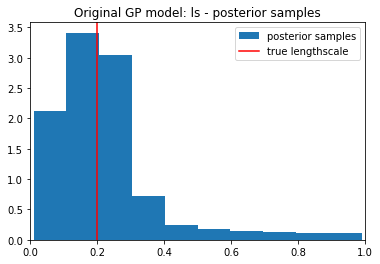

In [25]:
ls_samps = mcmc_samples['length']
plt.hist(ls_samps, density=True, label = 'posterior samples')
plt.axvline(x = true_ls, color = 'red', label = 'true lengthscale')
plt.xlim(0,1)
plt.title('Original GP model: ls - posterior samples')
plt.legend()
plt.show()

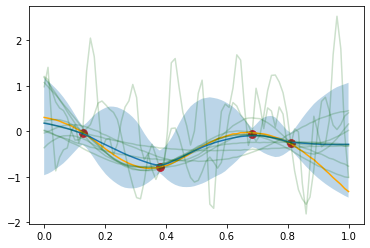

In [26]:
predictions_gp = mcmc_samples['f']

mean_post_pred_gp = jnp.mean(predictions_gp, axis=0)
hpdi_post_pred_gp = hpdi(predictions_gp, 0.9)
percentiles = np.percentile(predictions_gp, [5.0, 95.0], axis=0)

N_lines = 10
plt.plot(args["x"], gp_draw, label="ground truth", color="orange")
plt.scatter(x_obs, y_obs, color="red", label="observed data", s=60)
plt.plot(args["x"], mean_post_pred_gp, label="predicted mean")
plt.fill_between(args["x"], percentiles[0, :], percentiles[1, :], alpha=0.3, interpolate=True, label="GP posterior: 90% BCI")
for j in range(N_lines):
    itr = int(predictions_gp.shape[0]/N_lines)
    plt.plot(args["x"], predictions_gp[j* itr,:], alpha=0.2, color="darkgreen", label="")

array([[<AxesSubplot: title={'center': 'sigma'}>,
        <AxesSubplot: title={'center': 'sigma'}>]], dtype=object)

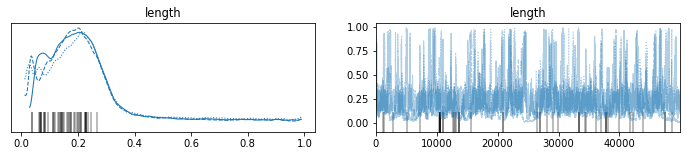

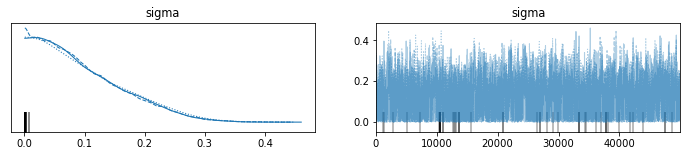

In [28]:
import arviz as az

az_data = az.from_numpyro(mcmc)
#az.plot_trace(az_data, var_names=('f'), filter_vars="like")
az.plot_trace(az_data, var_names=('length'), filter_vars="like")
az.plot_trace(az_data, var_names=('sigma'))

In [29]:
fname = 'mcmc/gp1d_n' + str(n_dataPoints) + '_niter' + str(args["num_samples"] + args["num_warmup"]) + '.pkl'
print(fname)

mcmc/gp1d_n80_niter55000.pkl


In [30]:
with open(fname, 'wb') as f:
    dill.dump(mcmc, f)

In [34]:
#with open(fname, 'rb') as f:
#    mcmc = dill.load(f)